# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance

## import dependencies

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
from binance import Client
from config import API_Key,Secret_Key


## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date and Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date and Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating crypto df

In [5]:
crypto_df= get_crypto_data('BTCUSDT','1m','1 week').tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(10080, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date and Time,,,,,
2021-11-18 08:56:00-06:00,58817.99,58951.45,58770.00,58882.26,99.36921
2021-11-18 08:57:00-06:00,58882.26,58926.46,58840.57,58924.89,47.71533
2021-11-18 08:58:00-06:00,58924.90,59129.05,58924.89,58953.23,58.11051
2021-11-18 08:59:00-06:00,58953.22,58961.35,58841.87,58906.65,28.05708
2021-11-18 09:00:00-06:00,58906.26,58986.48,58840.39,58986.01,22.60597
2021-11-18 09:01:00-06:00,58986.01,59099.04,58944.89,59032.74,51.83650
2021-11-18 09:02:00-06:00,59032.73,59066.13,58997.30,59020.85,34.02491
2021-11-18 09:03:00-06:00,59020.86,59049.98,59015.44,59036.98,23.50681
2021-11-18 09:04:00-06:00,59036.98,59036.98,58966.38,58993.47,20.27868


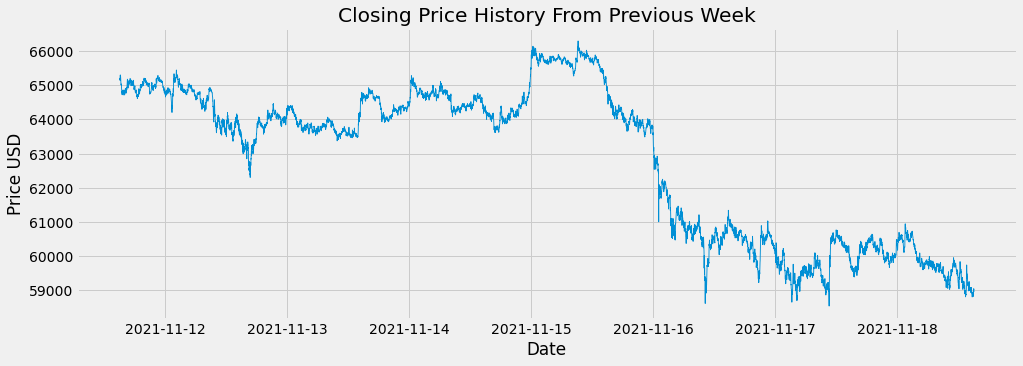

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title('Closing Price History From Previous Week')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.show()

## code machine larning: Linear regresion

In [8]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(14)

,Last
Date and Time,
2021-11-11 09:06:00-06:00,65139.38
2021-11-11 09:07:00-06:00,65167.42
2021-11-11 09:08:00-06:00,65192.89
2021-11-11 09:09:00-06:00,65209.49
2021-11-11 09:10:00-06:00,65200.02
2021-11-11 09:11:00-06:00,65149.99
2021-11-11 09:12:00-06:00,65299.99
2021-11-11 09:13:00-06:00,65226.43
2021-11-11 09:14:00-06:00,65290.02


In [9]:
#  variable for predicting x number of periods into the future
predict_periods = 14 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-9-ecb9c1ecbcbf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)


In [10]:
# show df with new column
crypto_last_price_df.head(14)

,Last,Prediction
Date and Time,,
2021-11-11 09:06:00-06:00,65139.38,65033.47
2021-11-11 09:07:00-06:00,65167.42,65035.91
2021-11-11 09:08:00-06:00,65192.89,65007.19
2021-11-11 09:09:00-06:00,65209.49,65027.66
2021-11-11 09:10:00-06:00,65200.02,65030.50
2021-11-11 09:11:00-06:00,65149.99,64960.26
2021-11-11 09:12:00-06:00,65299.99,64967.87
2021-11-11 09:13:00-06:00,65226.43,64906.50
2021-11-11 09:14:00-06:00,65290.02,64873.00


In [11]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(15)

,Last,Prediction
Date and Time,,
2021-11-18 08:51:00-06:00,58870.00,58946.02
2021-11-18 08:52:00-06:00,58892.54,NaN
2021-11-18 08:53:00-06:00,58821.32,NaN
2021-11-18 08:54:00-06:00,58853.93,NaN
2021-11-18 08:55:00-06:00,58817.99,NaN
2021-11-18 08:56:00-06:00,58882.26,NaN
2021-11-18 08:57:00-06:00,58924.89,NaN
2021-11-18 08:58:00-06:00,58953.23,NaN
2021-11-18 08:59:00-06:00,58906.65,NaN


In [12]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[65139.38]
 [65167.42]
 [65192.89]
 ...
 [58829.3 ]
 [58885.97]
 [58870.  ]]


In [13]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[65033.47 65035.91 65007.19 ... 59036.98 58993.47 58946.02]


In [14]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [15]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

In [16]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.8318891282249509


In [17]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[58892.54]
 [58821.32]
 [58853.93]
 [58817.99]
 [58882.26]
 [58924.89]
 [58953.23]
 [58906.65]
 [58986.01]
 [59032.74]
 [59020.85]
 [59036.98]
 [58993.47]
 [58946.02]]


In [18]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[58901.71797378 58830.77192928 58863.25649136 58827.45473849
 58891.47751692 58933.94353597 58962.17452307 58915.77369812
 58994.82843122 59041.37867917 59029.53441535 59045.60236955
 59002.25973551 58954.99225712]


In [19]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual price', 'predicted price'])
results_df

,actual price,predicted price
0,[58892.54],58901.717974
1,[58821.32],58830.771929
2,[58853.93],58863.256491
3,[58817.99],58827.454738
4,[58882.26],58891.477517
5,[58924.89],58933.943536
6,[58953.23],58962.174523
7,[58906.65],58915.773698
8,[58986.01],58994.828431
9,[59032.74],59041.378679


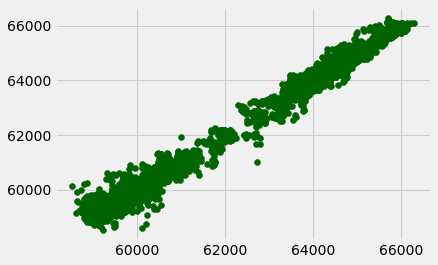

In [20]:
plt.scatter(a, b, color="DarkGreen" )

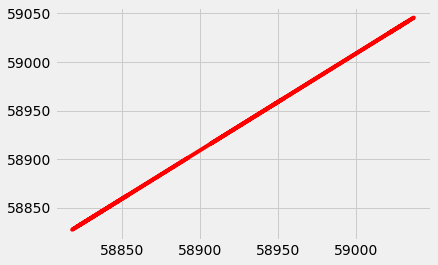

In [21]:
plt.plot(a_projection,Lreg_predict, color='r')

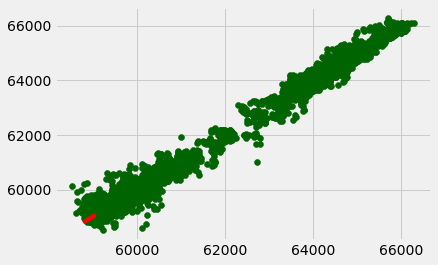

In [22]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## MACD df

In [23]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


,Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
Date and Time,,,,,,,,,
2021-11-18 08:46:00-06:00,58818.97,58858.42,58801.03,58822.36,32.84162,58876.531798,58938.430495,-61.898698,-50.916610
2021-11-18 08:47:00-06:00,58822.35,58919.42,58820.96,58919.41,54.53872,58883.128444,58937.021570,-53.893126,-51.511913
2021-11-18 08:48:00-06:00,58919.42,58941.98,58875.10,58875.11,23.66965,58881.894837,58932.435527,-50.540690,-51.317668
2021-11-18 08:49:00-06:00,58875.11,58880.76,58815.04,58829.30,21.08882,58873.803324,58924.795859,-50.992535,-51.252642
2021-11-18 08:50:00-06:00,58829.30,58979.67,58826.11,58885.97,67.73530,58875.675120,58921.919869,-46.244749,-50.251063
2021-11-18 08:51:00-06:00,58885.97,58925.82,58870.00,58870.00,40.43882,58874.802025,58918.073953,-43.271928,-48.855236
2021-11-18 08:52:00-06:00,58870.00,58900.00,58856.08,58892.54,15.76049,58877.530944,58916.182549,-38.651605,-46.814510
2021-11-18 08:53:00-06:00,58892.54,58899.90,58800.00,58821.32,25.73230,58868.883107,58909.155694,-40.272587,-45.506125
2021-11-18 08:54:00-06:00,58821.32,58859.97,58792.00,58853.93,48.25567,58866.582629,58905.064901,-38.482273,-44.101355


## MACD buy and sell notification

In [24]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [100]:
#create buy and sell columns in df
x=alert_MACD(crypto_MACD_df)
crypto_MACD_df['Buy Notification'] = x[0]
crypto_MACD_df['Sell Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['Buy Notification', 'Sell Notification']]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(30)

,Buy Notification,Sell Notification
Date and Time,,
2021-11-18 09:05:00-06:00,0,0
2021-11-18 09:04:00-06:00,0,0
2021-11-18 09:03:00-06:00,0,0
2021-11-18 09:02:00-06:00,0,0
2021-11-18 09:01:00-06:00,0,0
2021-11-18 09:00:00-06:00,0,0
2021-11-18 08:59:00-06:00,0,0
2021-11-18 08:58:00-06:00,0,0
2021-11-18 08:57:00-06:00,0,0


## BOLLINGER BANDS df

In [26]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.head()

,Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
Date and Time,,,,,,,,,
2021-11-11 09:06:00-06:00,65082.38,65166.61,65082.38,65139.38,22.14632,NaN,NaN,NaN,NaN
2021-11-11 09:07:00-06:00,65139.37,65194.57,65111.52,65167.42,21.39324,NaN,NaN,NaN,NaN
2021-11-11 09:08:00-06:00,65167.41,65247.00,65154.83,65192.89,20.16201,NaN,NaN,NaN,NaN
2021-11-11 09:09:00-06:00,65192.89,65239.13,65175.25,65209.49,12.85350,NaN,NaN,NaN,NaN
2021-11-11 09:10:00-06:00,65204.74,65233.66,65193.56,65200.02,28.50482,NaN,NaN,NaN,NaN


## BBand buy sell Notification

In [104]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [106]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['Buy Notification'] = x[0]
crypto_BBand_df['Sell Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['Buy Notification', 'Sell Notification']]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(30)

,Buy Notification,Sell Notification
Date and Time,,
2021-11-18 09:05:00-06:00,0,0
2021-11-18 09:04:00-06:00,0,0
2021-11-18 09:03:00-06:00,0,0
2021-11-18 09:02:00-06:00,0,0
2021-11-18 09:01:00-06:00,0,0
2021-11-18 09:00:00-06:00,1,0
2021-11-18 08:59:00-06:00,0,0
2021-11-18 08:58:00-06:00,0,0
2021-11-18 08:57:00-06:00,0,0


## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [109]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['Buy Notification'][i] == df2['Buy Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['Sell Notification'][i]== df2['Sell Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [136]:
#create buy and sell columns in df
x=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy Notification'] = x[0]
crypto_alert_df['Sell Notification'] = x[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy Notification', 'Sell Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(59)

,Buy Notification,Sell Notification
Date and Time,,
2021-11-18 09:05:00-06:00,0,0
2021-11-18 09:04:00-06:00,0,0
2021-11-18 09:03:00-06:00,0,0
2021-11-18 09:02:00-06:00,0,0
2021-11-18 09:01:00-06:00,0,0
2021-11-18 09:00:00-06:00,0,0
2021-11-18 08:59:00-06:00,0,0
2021-11-18 08:58:00-06:00,0,0
2021-11-18 08:57:00-06:00,0,0


In [132]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy Notification'] == 1]
crypto_buy_df

,Buy Notification,Sell Notification
Date and Time,,


In [133]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell Notification'] == 1]
crypto_sell_df

,Buy Notification,Sell Notification
Date and Time,,


In [29]:
crypto_df['Last'].describe()

count    10080.000000
mean     62866.011259
std       2201.769564
min      58533.400000
25%      60475.985000
50%      63846.905000
75%      64648.105000
max      66296.020000
Name: Last, dtype: float64

## Technical Indicators graphs

In [81]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title('MACD graph from previous week')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 1)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous hour')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title('BBands previous week')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour,now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

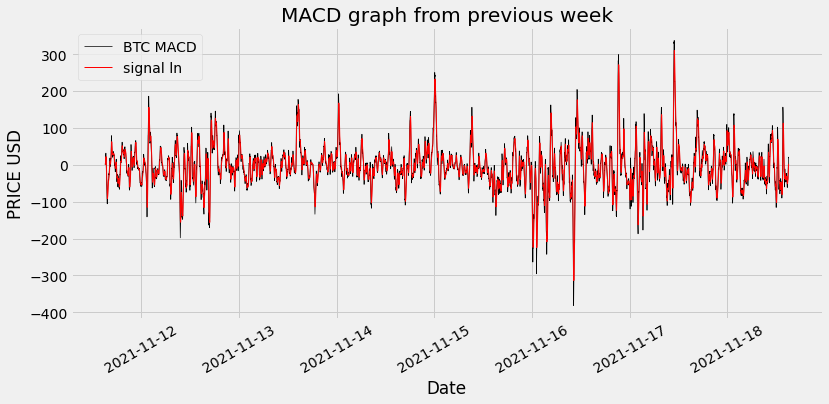

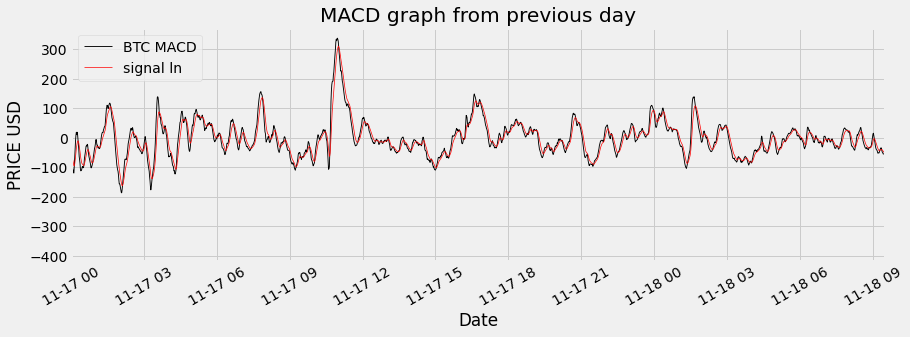

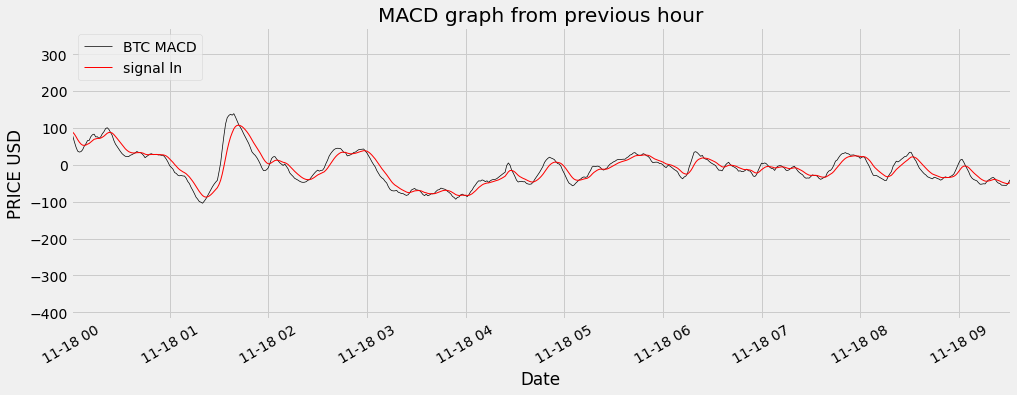

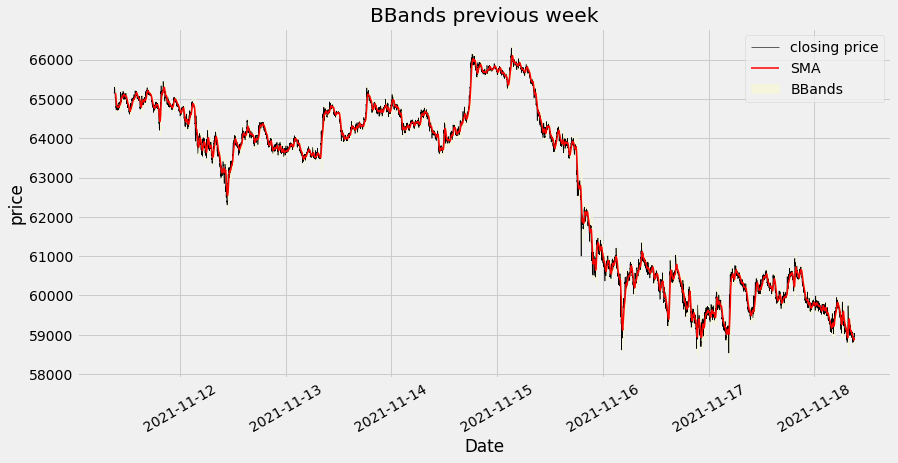

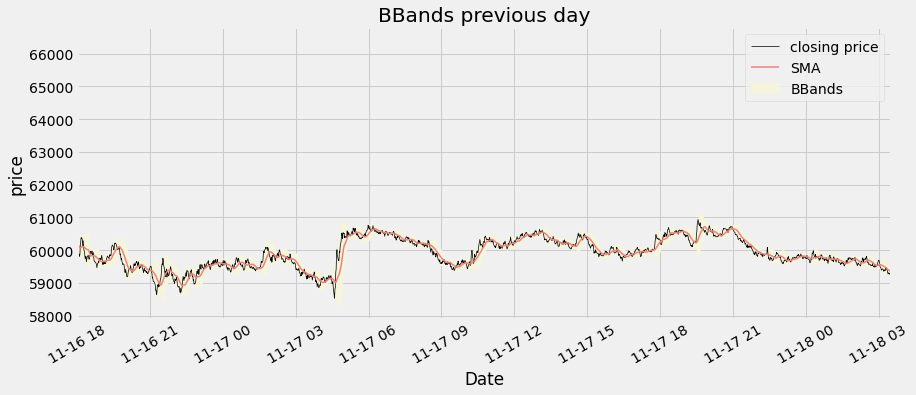

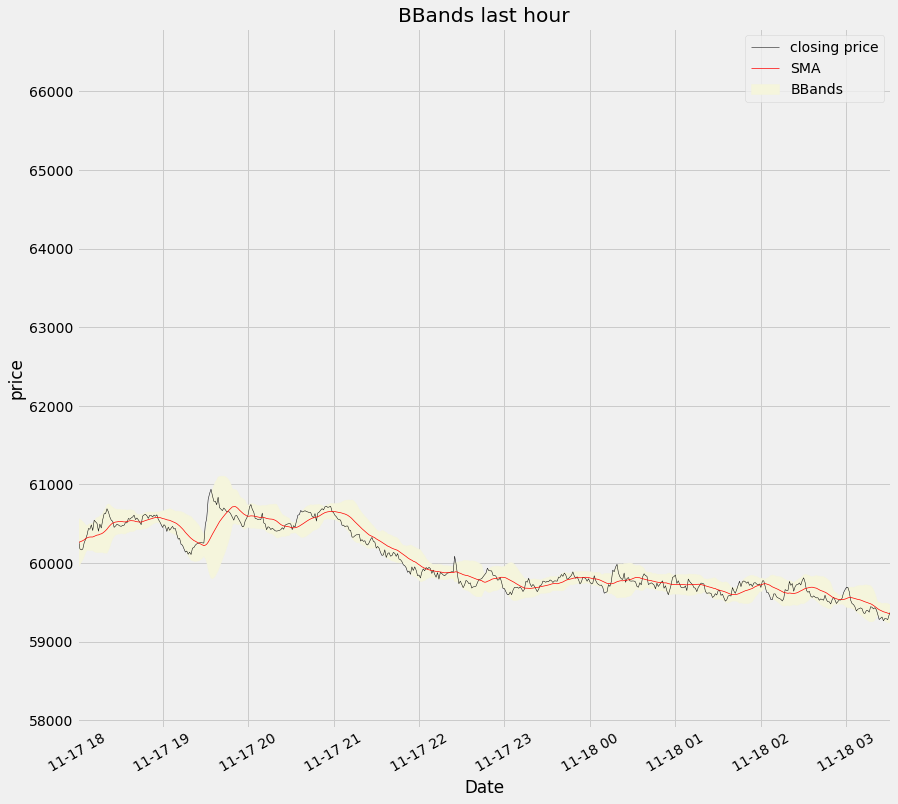

In [82]:
TI_graphs(crypto_df)